<a href="https://colab.research.google.com/github/Sirabhop/Preclinical-AD-EEG-classification/blob/master/Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
import os
import pandas as pd

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir("/content/drive/My Drive/EEG Data")

# **Descriptive Statistics**

####**Demographics**

In [0]:
dict = {'sex': ['male', 'female', 'female', 'female', 'female', 'female', 'female', 'female'],
        'ages':[63, 60, 66, 68, 72, 74, 61, 64],
        'group': [0,1,1,0,1,1,0,0]} #0 = Risk Free, 1 = At risk

In [30]:
df = pd.DataFrame(data = dict)
df

,sex,ages,group
0,male,63,0
1,female,60,1
2,female,66,1
3,female,68,0
4,female,72,1
5,female,74,1
6,female,61,0
7,female,64,0


####**Cognitive Markers**


In [0]:
FCSRT = pd.read_csv('FCSRT.csv')
FCSRT.drop(['id'], inplace = True, axis = 1)
MoCA = pd.read_csv('MoCA.csv')

In [0]:
CogMarkers = pd.concat([df, FCSRT, MoCA[['SUM']]], axis = 1)
CogMarkers.rename(columns = {'SUM':'MoCA'}, inplace = True)
CogMarkers.to_csv('cognitive marker.csv')

In [75]:
Cog_RiskFree = CogMarkers[CogMarkers['group'] == 0]
Cog_Risk = CogMarkers[CogMarkers['group'] == 1]
Cog_RiskFree

,sex,ages,group,IR-FreeR,IR-CuedR,DL-FreeR,DL-CuedR,MoCA
0,male,63,0,6,8,7,5,21
3,female,68,0,11,4,11,5,22
6,female,61,0,8,7,9,6,20
7,female,64,0,10,5,9,7,6


####**Biomarkers**

In [26]:
features = pd.read_csv('EEG_features.csv')
features.drop(['Unnamed: 0'], inplace = True, axis = 1)
Biomarkers = pd.concat([df, features], axis = 1)
Biomarkers

,sex,ages,group,id,PSD_Delta,PSD_Theta,PSD_Alpha,PSD_Beta,PSD_Gamma,MSF,SE,AC,wSMI_Alpha,wSMI_Theta
0,male,63,0,SS1,NaN,7.279026e-12,7.279026e-12,1.973301e-12,1.858662e-12,2.040890e-13,2.513122,0.047027,0.062951,0.030738
1,female,60,1,SS2,NaN,1.462029e-12,1.462029e-12,8.044949e-13,3.229391e-13,3.377435e-13,2.476574,0.052528,0.070597,0.034804
2,female,66,1,SS3,NaN,1.932887e-12,1.932887e-12,3.683971e-12,7.096728e-12,5.726507e-13,2.483961,0.064709,0.074569,0.037275
3,female,68,0,SS4,NaN,2.068102e-09,2.068102e-09,1.348127e-10,1.989188e-11,4.433322e-13,2.476574,0.051643,0.077876,0.039141
4,female,72,1,SS5,NaN,1.534075e-12,1.534075e-12,9.461273e-13,4.538757e-13,3.837676e-13,2.407455,0.059398,0.080348,0.040611
5,female,74,1,SS6,NaN,9.100334e-13,9.100334e-13,4.259585e-13,4.087238e-13,1.819820e-13,2.407455,0.054304,0.082285,0.041790
6,female,61,0,SS7,NaN,4.729273e-12,4.729273e-12,2.664199e-12,3.828348e-12,8.676798e-13,2.492098,0.055813,0.083638,0.042501
7,female,64,0,SS8,NaN,1.005613e-12,1.005613e-12,9.943775e-13,1.220265e-12,3.364207e-13,2.407455,0.065214,0.084809,0.043116


# **Inferencial Statistics**

####**Cognitive Markers**

In [0]:
import scipy
import matplotlib.pyplot as plt

* 1-way ANOVA (Risk vs Free Risk)



In [56]:
#Encoding
print(scipy.stats.f_oneway(Cog_Risk['IR-CuedR'],Cog_RiskFree['IR-CuedR'])) #sig

#Retrieval
print(scipy.stats.f_oneway(Cog_Risk['IR-FreeR'],Cog_RiskFree['IR-FreeR'])) #sig

F_onewayResult(statistic=3.4186046511627906, pvalue=0.11395633124158694)
F_onewayResult(statistic=0.023622047244094488, pvalue=0.8828895569688998)


In [76]:
CogMarkers2 = CogMarkers
CogMarkers2['group'][CogMarkers2['group'] == 0] = 'Normal'
CogMarkers2['group'][CogMarkers2['group'] == 1] = 'Risk'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [78]:
CogMarkers2

,sex,ages,group,IR-FreeR,IR-CuedR,DL-FreeR,DL-CuedR,MoCA
0,male,63,Normal,6,8,7,5,21
1,female,60,Risk,7,5,9,5,7
2,female,66,Risk,11,4,11,4,9
3,female,68,Normal,11,4,11,5,22
4,female,72,Risk,10,4,7,7,12
5,female,74,Risk,6,4,6,4,15
6,female,61,Normal,8,7,9,6,20
7,female,64,Normal,10,5,9,7,6


No handles with labels found to put in legend.


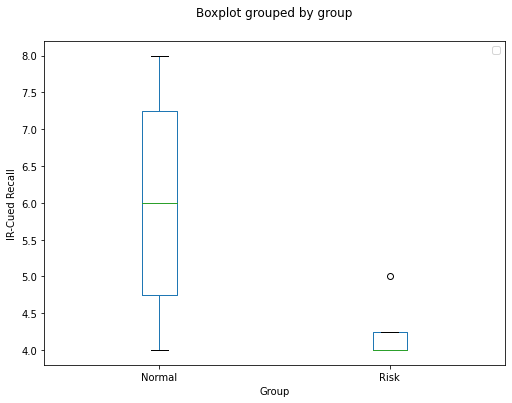

In [79]:
CogMarkers2.boxplot(column = ['IR-CuedR'], by = ['group'], grid = False, figsize = (8,6))
plt.title(None)
plt.xlabel('Group')
plt.ylabel('IR-Cued Recall')
plt.legend()
plt.show()

####**Biomarkers**